# Assignment 2 - Circuit Simulation

`Nilaksh | 20EC10102`

---

This assignment involves writing a code to simulate a given circuit and find the outputs in Laplace domain ($s$ domain). The program takes the circuit as a v-shifted and i-shifted circuit as an input in the following format for each branch:

 src node | dest node | L | R | C | voltage src | current src
---------|-----------|---|---|---|-------------|------------
-|-|-|-|-|-|-

The values of inductance, resistance and capacitance are taken in $mH$, $k𝛀$, and $\mu F$ respectively. The voltage and current sources are entered as a set of three values specifying the amplitude, frequency and phase of a sine wave. 

The program solves the circuit by first representing the circuit network as a directed graph and then forming a tree. Then it calculates the fundamental loop matrix B and the fundamental cutet matrix Q which are used to solve for the currents and voltages.




##Entering the input matrix

The input matrix, in the format specified above, is read as a CSV file.


In [ ]:
#downloading the input file
#here an example input file is used, you can replace with a different file
!wget -O input.csv https://raw.githubusercontent.com/hskalin/circuitSim/main/input-example.csv

#displaying the raw input file
!cat input.csv

--2021-11-07 13:58:53--  https://raw.githubusercontent.com/hskalin/circuitSim/main/input-example.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206 [text/plain]
Saving to: ‘input.csv’

input.csv           100%[===================>]     206  --.-KB/s    in 0s      

2021-11-07 13:58:53 (15.9 MB/s) - ‘input.csv’ saved [206/206]

src,dest,L,R,C,V_amp, V_freq, V_phase, I_amp, I_freq, I_phase
4,1,0,1,0,5,1000,0,0,0,0
1,2,0,3,0,0,0,0,0,0,0
1,3,0,0,0.1,0,0,0,0,0,0
2,3,0,2,0,0,0,0,0,0,0
2,4,1,0,0,0,0,0,0,0,0
3,4,0.5,0,0,0,0,0,2,2000,0.5


In [ ]:
import pandas as pd

#reading the input file
input = pd.read_csv('input.csv')

# displaying the input marrix
input


,src,dest,L,R,C,V_amp,V_freq,V_phase,I_amp,I_freq,I_phase
0,4,1,0.0,1,0.0,5,1000,0,0,0,0.0
1,1,2,0.0,3,0.0,0,0,0,0,0,0.0
2,1,3,0.0,0,0.1,0,0,0,0,0,0.0
3,2,3,0.0,2,0.0,0,0,0,0,0,0.0
4,2,4,1.0,0,0.0,0,0,0,0,0,0.0
5,3,4,0.5,0,0.0,0,0,0,2,2000,0.5


Here the matrix entered corresponds to the following circuit :

![circuit1](https://github.com/hskalin/circuitSim/raw/main/circuit--example.png)

The voltage source VG1 is $5\sin(2\pi 1000t)$ volts and IG1 is $2\cos(2\pi 2000t)$ amps.

In [ ]:
# extracting the branches of the circuit and storing them as
# a list of pair of nodes
graphEdgeList = []
for index, row in input.iterrows():
  tmpRow = [int(row['src']), int(row['dest'])]
  graphEdgeList.append(tmpRow)

graphEdgeList

[[4, 1], [1, 2], [1, 3], [2, 3], [2, 4], [3, 4]]

##Forming the graph

Now we need to make a graph from the list of edges (branches). This is done using the networkx library

In [ ]:
# First networkx library is imported 
# along with matplotlib
import networkx as nx
import matplotlib.pyplot as plt

# Defining a Class
class GraphVisualization:
   
  def __init__(self, edgeList, indexList):
    self.visual = []
    self.edgeLabels = {}
  
    self.makeGraph(edgeList, indexList)
    self.G = nx.MultiGraph()
    self.G.add_edges_from(self.visual)
  
  # addEdge function inputs the vertices of an
  # edge and appends it to the visual list
  def addEdge(self, a, b, val= r'$\pi$'):
    temp = [a, b]
    self.visual.append(temp)
    self.edgeLabels[(a,b)] = val

  def makeGraph(self, edgeList, indexList):
    for i, row in enumerate(edgeList):
      self.addEdge(row[1], row[0], indexList[i]+1)

  #f function to draw the graph
  def visualize(self):
  
    pos = nx.spring_layout(self.G)
   
    nx.draw_networkx_nodes(self.G, pos, node_color = '#cccccc')
    nx.draw_networkx_labels(self.G, pos)
    
    nx.draw_networkx_edge_labels(self.G, pos, edge_labels=self.edgeLabels)

    ax = plt.gca()
    
    for e in self.G.edges:
        ax.annotate("",
                    xy=pos[e[0]], xycoords='data',
                    xytext=pos[e[1]], textcoords='data',
                    arrowprops=dict(arrowstyle="->", color="0.5",
                                    shrinkA=15, shrinkB=15,
                                    patchA=None, patchB=None,
                                    connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*e[2])
                                    ),
                                    ),
                    )
        
    plt.axis('off')
    plt.show()


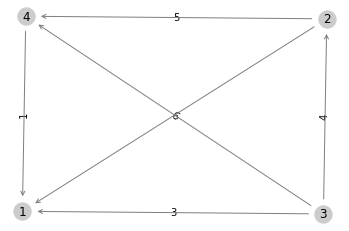

In [ ]:
# Visualizing the network
net = GraphVisualization(graphEdgeList, [x for x in range(len(graphEdgeList))])
# getting the graph and plotting it
net.visualize()

##Forming the Tree

Now we need to make a tree from the obtained graph. A tree is a subgraph which has the same number of nodes as the original graphs and has no loops. 

The edges that make a tree are called __twigs__ and the rest of the edges from the original graph are called __links__.

In [ ]:
# these store the pair of nodes defining an edge
treeEdgeList = []
linkEdgeList = []

# these store the index of the edges / branches as per the graphEdgeList
treeIndexList = []
linkIndexList = []

#function to check if adding an egde makes a loop
def makesLoop(edge, edgeList):
  flagA = False
  flagB = False

  # checking if both nodes are already present
  for row in edgeList:
    if edge[0] in row:
      flagA = True
    if edge[1] in row:
      flagB = True

  if flagA and flagB:
    return True
    
  return False 


for i, edge in enumerate(graphEdgeList):
  if makesLoop(edge, treeEdgeList):
    linkEdgeList.append(edge)
    linkIndexList.append(i)
  else:
    treeEdgeList.append(edge)
    treeIndexList.append(i)

# prints the tree and link branches
print('tree = ', [x+1 for x in treeIndexList])
print('link = ', [x+1 for x in linkIndexList])


tree =  [1, 2, 3]
link =  [4, 5, 6]


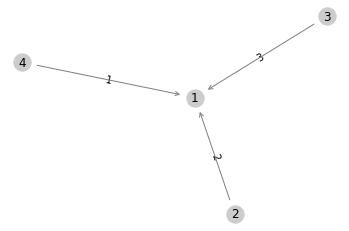

In [ ]:
#plotting the tree
tree = GraphVisualization(treeEdgeList, treeIndexList)
tree.visualize()



##About Laplace Transform

We will be using the laplace transform in the following sections to convert the expressions into $s$-domain in order to solve them. Then we will take the Inverse laplace transform of the solved quantities to get them back in the time domain.

The Laplace transform is defined as

$$\mathcal{L}\{f(t)\} = \int_{0}^{\infty}f\left(t\right)e^{-st}ds$$


In [ ]:
#importing sympy for computation
import sympy
sympy.init_printing()

import matplotlib.pyplot as plt
%matplotlib inline

from sympy.matrices import Matrix, eye, zeros, ones, diag
from sympy import nsimplify

#defining the variables
s = sympy.symbols('s', real=True)
t = sympy.symbols('t', real=True)
a = sympy.symbols('a', real=True, positive=True)

#defining Laplace and Inverse Laplace transform
def L(f):
  return sympy.laplace_transform(f, t, s, noconds=True)

def invL(F):
  return sympy.inverse_laplace_transform(F, s, t)


The Laplace transform of simple functions like $\sin$ and $\cos$ can be evaluated as follows:

In [ ]:
#Laplace transform of sine
sympy.integrate(sympy.sin(a*t)*sympy.exp(-s*t), (t, 0, sympy.oo))

⎧        1                              
⎪    ──────────       for 2⋅│arg(s)│ < π
⎪      ⎛     2⎞                         
⎪      ⎜    s ⎟                         
⎪    a⋅⎜1 + ──⎟                         
⎪      ⎜     2⎟                         
⎪      ⎝    a ⎠                         
⎨                                       
⎪∞                                      
⎪⌠                                      
⎪⎮  -s⋅t                                
⎪⎮ ℯ    ⋅sin(a⋅t) dt      otherwise     
⎪⌡                                      
⎪0                                      
⎩                                       

In [ ]:
#we will utilize the builtin function for finding the laplace transform
L(sympy.sin(a*t))

##Matrices

In this section we will be calculating the various matrices required for solving the ciruit.

###Fundamental Loop Matrix

The fundamental Loop matrix consists of the loops that are formed by adding the links one at a time to the trees. The orientation of the loop is the same as the orientation of the link. Thus the fundamental loop matrix $B_f$ can be defined as:

$$B_f = 
\begin{bmatrix}
b_{ij}
\end{bmatrix}$$

where,

$$b_{ij} 
= \begin{cases} 
    +1 & \text{If } j^{th} \text{ branch has the same orientation as } i^{th}  \text{ loop} \\
    -1 & \text{If } j^{th} \text{ branch has differnt orientation than the } i^{th}  \text{ loop} \\
    0 & \text{If the branch is not a part of the loop} 
  \end{cases}$$

Thus we can see that $B_f$ has the dimention $b-n\times b$. The matrix can be represented as a concatenation of two matrices - $B_t$ and $B_l$ which are the twig and link loop matrices respectively.

$$B_f = 
\begin{bmatrix}
B_t & B_l
\end{bmatrix}$$

We can also observe that $B_l$ is an identity matrix of dimention $b-n$.

In [ ]:

# function to get the loop containing the link
def getLoop(startNode, endNode, edgeList):
  path = nx.shortest_path(tree.G, source=endNode, target=startNode)

  loop = []

  for i in range(0, len(path)-1):
    loop.append([path[i], path[i+1]])
  
  return loop

# fundamental tree loop matrix Bt
Bt = []

#for each link edge
for link in linkEdgeList:
  loop = getLoop(link[0], link[1], treeEdgeList)
  row = []
  for edge in treeEdgeList:
    if edge in loop:
      row.append(1)
    elif list(reversed(edge)) in loop:
      row.append(-1)
    else:
      row.append(0)

  Bt.append(row)


In [ ]:
# the fundamental loop matrix
B = Matrix(sympy.BlockMatrix([[Matrix(Bt), eye(len(linkIndexList))]]))
B

⎡0  1  -1  1  0  0⎤
⎢                 ⎥
⎢1  1  0   0  1  0⎥
⎢                 ⎥
⎣1  0  1   0  0  1⎦

###Fundamental Cut Set matrix

A cutset is a set of branches of a connected graph if removing those branches will make two disconnected subgraphs, which are connected themselves. No proper subset of a cutset can be a cut set. 

The fundamental cut set matrix $Q_f$ is defined as:

$$Q_f = 
\begin{bmatrix}
q_{ij}
\end{bmatrix}$$

where,

$$q_{ij} = 
\begin{cases} 
  +1 & \text{If } j^{th} \text{ branch has the same orientation as } i^{th}  \text{ cut set} \\
  -1 & \text{If } j^{th} \text{ branch has differnt orientation than the } i^{th}  \text{ cut set} \\
  0 & \text{If the branch is not a part of the cut set} 
  \end{cases}$$

Thus we can see that $Q_f$ has the dimention $n\times b$. The matrix can be represented as a concatenation of two matrices - $Q_t$ and $Q_l$ which are the twig and link cut set matrices respectively.

$$Q_f = 
\begin{bmatrix}
Q_t & Q_l
\end{bmatrix}$$

We can also observe that $Q_t$ is an identity matrix of dimention $n$. 

Now there is an important relation between $B_t$ and $Q_l$ :

$$\boxed{B_t^T + Q_l = 0}$$

This relation has been utilized below to find $Q_f$




In [ ]:
# the fundamental cutset matrix

#getting B_t
B_t = B[0:len(linkIndexList), 0:len(treeIndexList)]

#getting Q_l
Q_l = -B_t.T

Q_l

⎡0   -1  -1⎤
⎢          ⎥
⎢-1  -1  0 ⎥
⎢          ⎥
⎣1   0   -1⎦

In [ ]:
# getting the fundamental Q matrix

Q = Matrix(sympy.BlockMatrix([[eye(len(treeIndexList)), Q_l]]))

Q

⎡1  0  0  0   -1  -1⎤
⎢                   ⎥
⎢0  1  0  -1  -1  0 ⎥
⎢                   ⎥
⎣0  0  1  1   0   -1⎦

###Voltage and Current Source Matrix

The independent current and voltage sources are represented as a vector $I_g$ and $V_g$ respectively. The sources corresponding to twig branches are listed first.

In [ ]:
from fractions import Fraction

# getting the V_g(s) matrix
Vg = []

for i in treeIndexList + linkIndexList:
  amp = input.iloc[i, 5]
  freq = input.iloc[i, 6]
  phase = input.iloc[i, 7]

  Vg.append(nsimplify(amp) * sympy.sin(2*sympy.pi*freq*t + nsimplify(phase)*sympy.pi))

# we take the Laplace trandform of Vg
Vg = L(Matrix(Vg))

Vg

⎡    10000⋅π    ⎤
⎢───────────────⎥
⎢ 2            2⎥
⎢s  + 4000000⋅π ⎥
⎢               ⎥
⎢       0       ⎥
⎢               ⎥
⎢       0       ⎥
⎢               ⎥
⎢       0       ⎥
⎢               ⎥
⎢       0       ⎥
⎢               ⎥
⎣       0       ⎦

In [ ]:
# getting the twig sources
Vgt = Vg[0:len(treeIndexList), :]

Vgt

⎡    10000⋅π    ⎤
⎢───────────────⎥
⎢ 2            2⎥
⎢s  + 4000000⋅π ⎥
⎢               ⎥
⎢       0       ⎥
⎢               ⎥
⎣       0       ⎦

In [ ]:
# getting the I_g(s) matrix
Ig = []

for i in treeIndexList + linkIndexList:
  amp = input.iloc[i, 8]
  freq = input.iloc[i, 9]
  phase = input.iloc[i, 10]

  Ig.append(nsimplify(amp) * sympy.sin(2*sympy.pi*freq*t + nsimplify(phase)*sympy.pi))

Ig = L(Matrix(Ig))

Ig

⎡       0        ⎤
⎢                ⎥
⎢       0        ⎥
⎢                ⎥
⎢       0        ⎥
⎢                ⎥
⎢       0        ⎥
⎢                ⎥
⎢       0        ⎥
⎢                ⎥
⎢      2⋅s       ⎥
⎢────────────────⎥
⎢ 2             2⎥
⎣s  + 16000000⋅π ⎦

In [ ]:
# getting the link sources
Igl = Ig[len(treeIndexList):len(linkIndexList+treeIndexList), :]
Igl

⎡       0        ⎤
⎢                ⎥
⎢       0        ⎥
⎢                ⎥
⎢      2⋅s       ⎥
⎢────────────────⎥
⎢ 2             2⎥
⎣s  + 16000000⋅π ⎦

###Impedance and Admittance matrix

The impedance matrix $Z$ and the admittance matrix $Y$ are diagonal matrices with the diagnal elements corresponding to the impedance/admittance of the $i^{th}$ branch, with twig branches listed first.

In [ ]:
# getting z impedance matrix
tmp = []

for i in treeIndexList + linkIndexList:
  z = 0
  if input.iloc[i, 2] != 0:
    z = z + nsimplify(input.iloc[i, 2]*0.001)*s 
  if input.iloc[i, 3] != 0:
    z = z + nsimplify(input.iloc[i, 3]*1000)
  if input.iloc[i, 4] != 0:
    z = z + 1/(nsimplify(input.iloc[i, 4]*0.000001)*s)

  tmp.append(z)

Z = []
for i in range(len(graphEdgeList)):
  row = []
  for j in range(len(graphEdgeList)):
    if i == j:
      row.append(tmp[i])
    else:
      row.append(0)
  Z.append(row)

Z = Matrix(Z)

Z

⎡1000   0       0       0     0     0  ⎤
⎢                                      ⎥
⎢ 0    3000     0       0     0     0  ⎥
⎢                                      ⎥
⎢            10000000                  ⎥
⎢ 0     0    ────────   0     0     0  ⎥
⎢               s                      ⎥
⎢                                      ⎥
⎢ 0     0       0      2000   0     0  ⎥
⎢                                      ⎥
⎢                             s        ⎥
⎢ 0     0       0       0    ────   0  ⎥
⎢                            1000      ⎥
⎢                                      ⎥
⎢                                   s  ⎥
⎢ 0     0       0       0     0    ────⎥
⎣                                  2000⎦

In [ ]:
# getting Y admitance matrix
tmp = []

for i in treeIndexList + linkIndexList:
  y = 0
  if input.iloc[i, 2] != 0:
    y = y + 1/(nsimplify(input.iloc[i, 2]*0.001)*s)
  if input.iloc[i, 3] != 0:
    y = y + 1/(nsimplify(input.iloc[i, 3]*1000))
  if input.iloc[i, 4] != 0:
    y = y + nsimplify(input.iloc[i, 4]*0.000001)*s


  tmp.append(y)

Y = []
for i in range(len(graphEdgeList)):
  row = []
  for j in range(len(graphEdgeList)):
    if i == j:
      row.append(tmp[i])
    else:
      row.append(0)
  Y.append(row)

Y = Matrix(Y)

Y

⎡1/1000    0        0        0      0     0  ⎤
⎢                                            ⎥
⎢  0     1/3000     0        0      0     0  ⎥
⎢                                            ⎥
⎢                   s                        ⎥
⎢  0       0     ────────    0      0     0  ⎥
⎢                10000000                    ⎥
⎢                                            ⎥
⎢  0       0        0      1/2000   0     0  ⎥
⎢                                            ⎥
⎢                                  1000      ⎥
⎢  0       0        0        0     ────   0  ⎥
⎢                                   s        ⎥
⎢                                            ⎥
⎢                                        2000⎥
⎢  0       0        0        0      0    ────⎥
⎣                                         s  ⎦

##Solving Voltages

For solving the voltages we can us the Kirchhoff's Voltage Law to get

$$B_{f}V=0$$

Now we know that $B_f$ can be represented as (here we use $U$ to denote an Identity matrix to avoid confustion with current matrix $I$) :

$$B_f = 
\begin{bmatrix}
B_t & B_l
\end{bmatrix}
=
\begin{bmatrix}
B_t & U_{b-n}
\end{bmatrix}
$$

Thus, on solving we get

$$V = Q_f^T V_t$$

This expression can be modified to accomodate independent voltage sources represented by $V_g$

$$V - V_g = Q_f^T (V_t - V_{gt})$$

Now on solving all these equations we obtain the following result for the voltages:

$$\boxed{V = Q_f^T Y_f^{-1} J + V_g - Q_f^T V_{gt}}$$

where,

$$Y_f = Q_f Y Q_f^T$$

$$J = Q_f [ I_g - Y V_g + Y Q_f^T V_{gt} ]$$



In [ ]:
Yf = Q*Y*Q.T
Yf

⎡ 1     3000     1000               2000         ⎤
⎢──── + ────     ────               ────         ⎥
⎢1000    s        s                  s           ⎥
⎢                                                ⎥
⎢   1000       1     1000                        ⎥
⎢   ────      ──── + ────         -1/2000        ⎥
⎢    s        1200    s                          ⎥
⎢                                                ⎥
⎢   2000                      s        1     2000⎥
⎢   ────        -1/2000    ──────── + ──── + ────⎥
⎣    s                     10000000   2000    s  ⎦

In [ ]:
J = Q*(Ig - Y*Vg + Y*Q.T*Vgt)
J

⎡        2⋅s               30000000⋅π    ⎤
⎢- ──────────────── + ───────────────────⎥
⎢   2             2     ⎛ 2            2⎞⎥
⎢  s  + 16000000⋅π    s⋅⎝s  + 4000000⋅π ⎠⎥
⎢                                        ⎥
⎢               10000000⋅π               ⎥
⎢          ───────────────────           ⎥
⎢            ⎛ 2            2⎞           ⎥
⎢          s⋅⎝s  + 4000000⋅π ⎠           ⎥
⎢                                        ⎥
⎢        2⋅s               20000000⋅π    ⎥
⎢- ──────────────── + ───────────────────⎥
⎢   2             2     ⎛ 2            2⎞⎥
⎣  s  + 16000000⋅π    s⋅⎝s  + 4000000⋅π ⎠⎦

In [ ]:
#solving for the voltages
V = Q.T*Yf.inv()*J + Vg - Q.T*Vgt
V

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

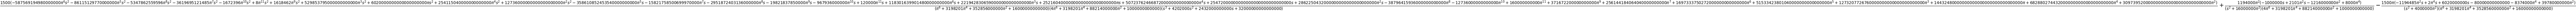

In [ ]:
# Vout corresponds to the 2nd branch
Vout = V[1].apart(s)
Vout

Now we got the expression for $Vout(s)$. For calculating the Inverse Laplace we will use MATLAB since SymPy is quite slow because of the large expression. we will copy the MATLAB compatible expression:

In [ ]:
#converting into MATLAB compatible expression
str(Vout).replace('**', '^')

'1500*(-587569194980000000*pi^6*s^2 - 86115129770000000*pi^5*s^2 - 5347862559596*pi^8*s^2 - 3619695121485*pi^7*s^2 - 1672396*pi^10*s^2 + 8*pi^11*s^2 + 1618462*pi^9*s^2 + 529853795000000000000*pi^3*s^2 + 6020000000000000000000*pi*s^2 + 254115040000000000000*pi^4*s^2 + 12736000000000000000000*pi^2*s^2 - 358610852453540000000000*pi^5*s - 15821758500699970000*pi^7*s - 2951872403136000000*pi^8*s - 19821837850000*pi^9*s - 967936000000*pi^10*s + 120000*pi^11*s + 118301639901480000000000*pi^6*s + 2219428306590000000000000000*pi^3*s + 25216040000000000000000000000*pi*s + 50723762466872000000000000000*pi^4*s + 25472000000000000000000000000000*s + 2862250432000000000000000000000*pi^2*s - 38796415936000000000000*pi^8 - 12736000000000000*pi^10 + 160000000000*pi^11 + 371672200000000000*pi^9 + 256144184064040000000000*pi^7 + 1697333750272000000000000000*pi^6 + 51533423801040000000000000000*pi^5 + 1273207726760000000000000000000000*pi^3 + 14432480000000000000000000000000000*pi + 6828802744320000000000

From MATLAB we get the following inverse for $Vout$ :



```
>> syms s

>> vout = ilaplace(vout)

 vout =

  (149144575922275318652804314920899625*symsum((exp(t*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k))*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k)^2)/(3*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k)^2 + 8404000*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k) + 2432000000000), k, 1, 3))/19569715248058241276798018422571008 - (1702995708578199331147957274913591*cos((2^(1/2)*5298703515892057^(1/2)*t)/8192))/276103312509917942713999125643264 - (1321219593405659036480225*pi*cos((2^(1/2)*5298703515892057^(1/2)*t)/16384))/2856217579187727757213696 + (21424462801418054805502969769043666375*symsum(exp(t*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k))/(3*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k)^2 + 8404000*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k) + 2432000000000), k, 1, 3))/1139107349332086816243712 + (2890642573232445984540231968334390895875*symsum((exp(root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k)*t)*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k))/(8404000*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k) + 3*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k)^2 + 2432000000000), k, 1, 3))/1194440627933242265429566554112 - (652182172790038294452224378233644009*2^(1/2)*5298703515892057^(1/2)*sin((2^(1/2)*5298703515892057^(1/2)*t)/8192))/11161724798170055908721127906620113455939584 + (16695050180368108687025*2^(1/2)*5298703515892057^(1/2)*pi*sin((2^(1/2)*5298703515892057^(1/2)*t)/16384))/1761858599376249219878663362616

>> fplot(vout, [0.01, 0.012])
>> 
```

Plotting this from 10ms to 12ms we get :

![mat_vout](https://github.com/hskalin/circuitSim/raw/main/matlab_vout.png)

##Solving Currents

For solving the voltages we can us the Kirchhoff's Current Law to get

$$Q_{f}I=0$$

Now we know that $Q_f$ can be represented as (here we use $U$ to denote an Identity matrix to avoid confustion with current matrix $I$) :

$$Q_f =
\begin{bmatrix}
Q_t & Q_l
\end{bmatrix}
=
\begin{bmatrix}
U_{n} & Q_l
\end{bmatrix}
$$

Thus, on solving we get

$$I = B_f^T I_l$$

This expression can be modified to accomodate independent voltage sources represented by $V_g$

$$I- I_g = B_f^T (I_l - I_{gl})$$

Now on solving all these equations we obtain the following result for the voltages:

$$\boxed{I = B_f^T Z_f^{-1} E + I_g - B_l^T I_{gl}}$$

where,

$$Z_f = B_f Z B_f^T$$

$$E = B_f [ V_g + Z B_f^T I_{gl} - Z I_g]$$


In [ ]:
Zf = B*Z*B.T
Zf

⎡       10000000                     -10000000       ⎤
⎢5000 + ────────     3000            ──────────      ⎥
⎢          s                             s           ⎥
⎢                                                    ⎥
⎢                  s                                 ⎥
⎢     3000        ──── + 4000           1000         ⎥
⎢                 1000                               ⎥
⎢                                                    ⎥
⎢  -10000000                    s            10000000⎥
⎢  ──────────        1000      ──── + 1000 + ────────⎥
⎣      s                       2000             s    ⎦

In [ ]:
E = B*(Vg + Z*B.T*Igl - Z*Ig)
E

⎡                     -20000000                       ⎤
⎢                  ────────────────                   ⎥
⎢                   2             2                   ⎥
⎢                  s  + 16000000⋅π                    ⎥
⎢                                                     ⎥
⎢              2000⋅s            10000⋅π              ⎥
⎢         ──────────────── + ───────────────          ⎥
⎢          2             2    2            2          ⎥
⎢         s  + 16000000⋅π    s  + 4000000⋅π           ⎥
⎢                                                     ⎥
⎢     2000⋅s            20000000           10000⋅π    ⎥
⎢──────────────── + ──────────────── + ───────────────⎥
⎢ 2             2    2             2    2            2⎥
⎣s  + 16000000⋅π    s  + 16000000⋅π    s  + 4000000⋅π ⎦

In [ ]:
I = B.T*Zf.inv()*E + Ig - B.T*Igl
I

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                     ⎛       
⎢                   2⋅s          ⎛     2000⋅s            10000⋅π    ⎞ ⎜       
⎢           - ──────────────── + ⎜──────────────── + ───────────────⎟⋅⎜───────
⎢              2             2   ⎜ 2             2    2            2⎟ ⎜ 3     
⎢             s  + 16000000⋅π    ⎝s  + 16000000⋅π    s  + 4000000⋅π ⎠ ⎜s  + 42
⎢                                                                     ⎜       
⎢                                                                     ⎝       
⎢                                                   

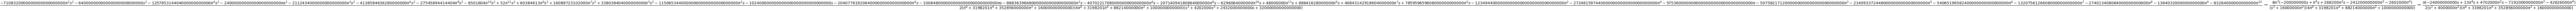

In [ ]:
# Iout corresponds to the 3rd branch
Iout = I[2].apart(s)
Iout

Now we got the expression for Iout(s). For calculating the Inverse Laplace we will use MATLAB since SymPy is quite slow because of the large expression. we will copy the MATLAB compatible expression:


In [ ]:
#converting into MATLAB compatible expression
str(Iout).replace('**', '^')

'(-7108320000000000000000000*pi^2*s^2 - 64000000000000000000000000*s^2 - 125785314404000000000000*pi^4*s^2 - 24000000000000000000000*pi*s^2 - 2112434000000000000000*pi^3*s^2 - 4138584636280000000*pi^6*s^2 - 27545894414404*pi^8*s^2 - 8501604*pi^10*s^2 + 52*pi^11*s^2 + 60384613*pi^9*s^2 + 16088723102000*pi^7*s^2 + 338038404000000000*pi^5*s^2 - 11506534400000000000000000000000*pi^2*s - 102400000000000000000000000000000*s - 204077619206400000000000000000*pi^4*s - 100848000000000000000000000000*pi*s - 8883639668000000000000000000*pi^3*s - 4070221708000000000000000*pi^6*s - 20714094180864000000*pi^8*s - 6296064000000*pi^10*s + 48000000*pi^11*s + 88641628000000*pi^9*s + 40843142918604000000*pi^7*s + 785959659608000000000000*pi^5*s - 123494400000000000000000000000000000*pi^2 - 2724815974400000000000000000000000*pi^4 - 57536000000000000000000000000000000*pi - 5075821712000000000000000000000000*pi^3 - 214093372448000000000000000000*pi^5 - 54065196582400000000000000000*pi^6 - 13207561266080000000

From MATLAB we get the following inverse for $Iout$ :



```
>> syms s

>> iout = ilaplace(iout)
 
 iout =
  
  (9645012687964642209277553266185668505*cos((2^(1/2)*5298703515892057^(1/2)*t)/8192))/1158061228073598866797097388682044768256 - (39340212506943579352936776423617667*symsum((exp(t*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k))*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k)^2)/(3*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k)^2 + 8404000*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k) + 2432000000000), k, 1, 3))/19569715248058241276798018422571008 + (21069802216192208930887*pi*cos((2^(1/2)*5298703515892057^(1/2)*t)/16384))/34274610950252733086564352 - (434521968226768654675295159651*symsum(exp(t*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k))/(3*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k)^2 + 8404000*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k) + 2432000000000), k, 1, 3))/17381398763001812992 - (30264307518647338409410843019145889*symsum((exp(root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k)*t)*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k))/(8404000*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k) + 3*root(z^3 + 4202000*z^2 + 2432000000000*z + 32000000000000000, z, k)^2 + 2432000000000), k, 1, 3))/9331567405728455198668488704 + (110964157265672500285515085286410025*2^(1/2)*5298703515892057^(1/2)*sin((2^(1/2)*5298703515892057^(1/2)*t)/8192))/1428700774165767156316304372047374522360266752 + (74434579805030655341*2^(1/2)*5298703515892057^(1/2)*pi*sin((2^(1/2)*5298703515892057^(1/2)*t)/16384))/26427878990643738298179950439240

>> fplot(iout, [0.01, 0.012])
>> 
```


Plotting this from 10ms to 12ms we get :

![mat_iout](https://github.com/hskalin/circuitSim/raw/main/matlab_iout.png)

##Result Verification

In order to verify the results the circuit was simulated in **TINA TI**. The circuit is as follows:

![circuit1](https://github.com/hskalin/circuitSim/raw/main/circuit--example.png)

The voltage source VG1 is $5\sin(2\pi 1000t)$ volts and IG1 is $2\cos(2\pi 2000t)$ amps.

The output plots are as follows : 



1.   Voltage $Vout$

![tin_vout](https://github.com/hskalin/circuitSim/raw/main/tina_vout.jpg)


2.   Current $Iout$

![tin_iout](https://github.com/hskalin/circuitSim/raw/main/tina_iout.jpg)


Thus by comparing the above plots by the ones obtained from MATLAB by plotting the calculated $Vout$ and $Iout$, we can conclude that the calculated expressions are correct.